In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [50]:
def lirinzel_ns(v2, a2, IP3, d5, k3, Ca0, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 338, dt)
    dt = dt
    Ca, h = [Ca0], [Ca0]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

In [86]:
def normalisation(k_Ca):
    min_Ca = np.min(k_Ca)
    max_Ca = np.max(k_Ca)
    return (k_Ca - min_Ca) / (max_Ca - min_Ca)

In [11]:
df = pd.read_excel("Data/experimental.xlsx", header=None)
df

,0,1
0,1.010594,1.015694
1,1.021187,1.051569
2,1.010736,1.096565
3,1.000037,1.108576
4,1.019003,1.077579
...,...,...
333,1.023147,1.709448
334,1.031264,1.653555
335,1.029415,1.513053
336,1.020254,1.366173


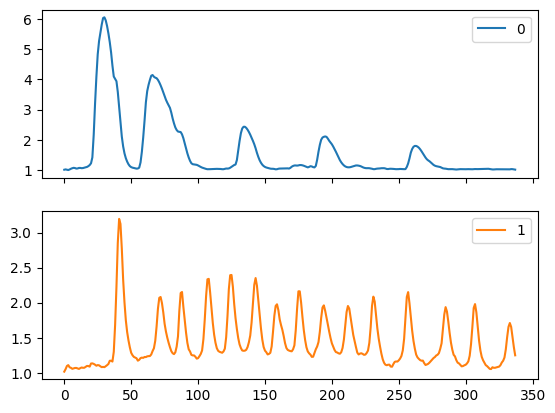

In [12]:
Ca_1 = df.iloc[:, 0]
Ca_2 = df.iloc[:, 1]
df.plot(subplots=True)
plt.show()

In [88]:
Ca_1 = np.array(Ca_1)
Ca_2 = np.array(Ca_2)

Ca_1_norm = normalisation(Ca_1)
Ca_2_norm = normalisation(Ca_2)

In [166]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1, std=1.0):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        self.std = std
        mean = 0.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, std, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features, std=std)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

# Experimental Data - 1

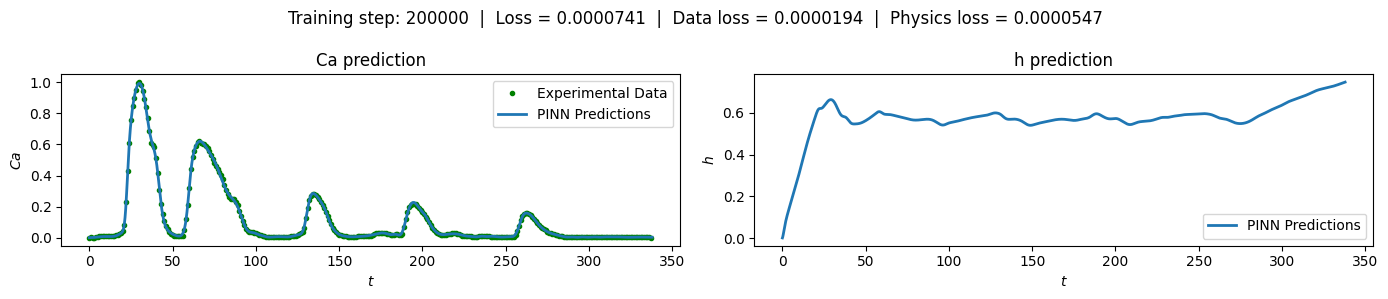

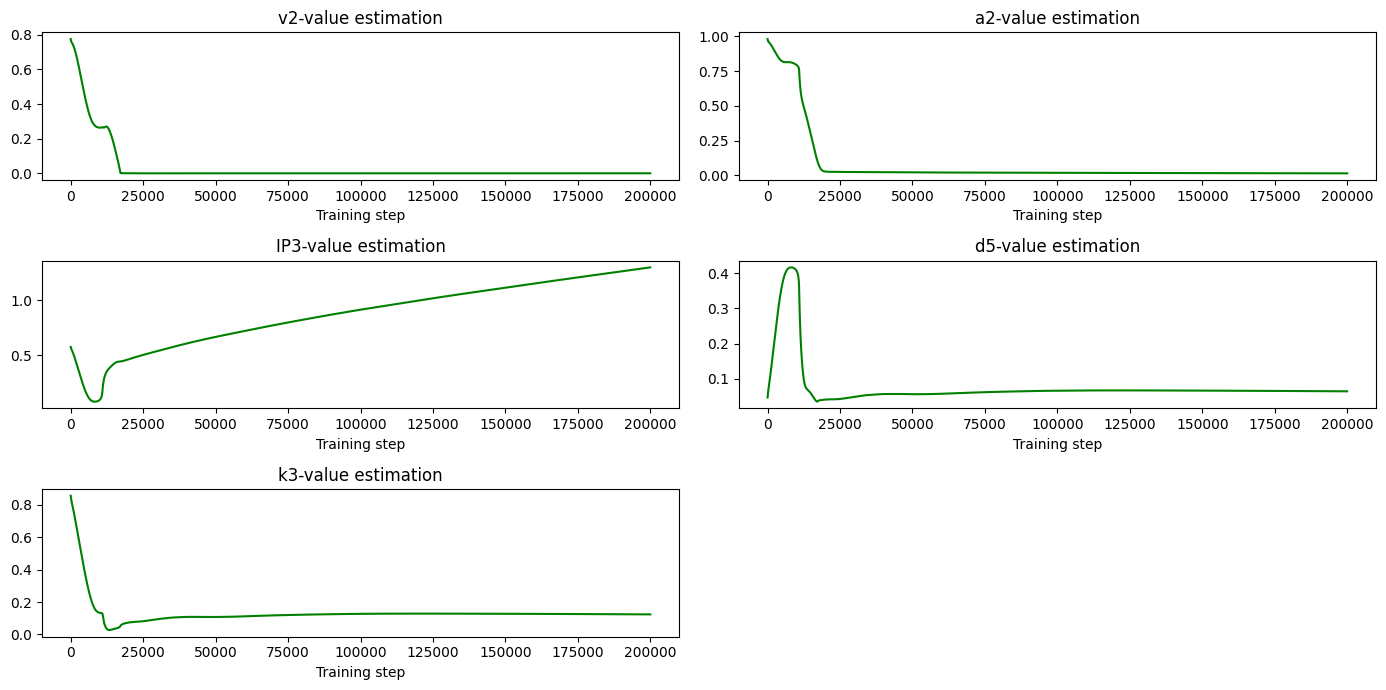

Epoch 200000 completed Successfully !


In [203]:
torch.manual_seed(42)
y0 = torch.tensor([Ca_1_norm[0], Ca_1_norm[0]]).view(1,-1)
pinn = PinnModel(hidden_units=30, num_features=3, std=0.1, y0=y0)

Ca_exp = torch.tensor(Ca_1_norm, dtype=torch.float)
t_test = torch.arange(0, 338, 0.1).view(-1, 1)
time = torch.arange(0, 338, 1.0).view(-1, 1)
t_physics = torch.linspace(0, 338, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
IP3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
d5 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
k3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))

lam1, lam2 = 1e-2, 1.5e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2, IP3, d5, k3], lr=0.0001)
epochs =  200001

v2s = []
a2s = []
IP3s = []
d5s = []
k3s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_exp)**2)

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss3 = torch.mean((res1)**2)
    loss4 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1) + lam2*(loss3 + loss4)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())
    IP3s.append(IP3.item())
    d5s.append(d5.item())
    k3s.append(k3.item())

    if i % 10000 == 0:

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        clear_output(wait=True)

        plt.figure(figsize=(14, 3))
        plt.suptitle(f"Training step: {i}  |  Loss = {loss1+loss3+loss4:.7f}  |  Data loss = {loss1:.7f}  |  Physics loss = {loss3+loss4:.7f}")
        plt.subplot(121)
        plt.plot(time.squeeze().cpu(), Ca_exp.detach().cpu(), '.g', label="Experimental Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(122)
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(14, 7))
        plt.subplot(321)
        plt.plot(v2s, c='green')
        plt.title("v2-value estimation")
        plt.xlabel("Training step")

        plt.subplot(322)
        plt.plot(a2s, c='green')
        plt.title("a2-value estimation")
        plt.xlabel("Training step")

        plt.subplot(323)
        plt.plot(IP3s, c='green')
        plt.title("IP3-value estimation")
        plt.xlabel("Training step")

        plt.subplot(324)
        plt.plot(d5s, c='green')
        plt.title("d5-value estimation")
        plt.xlabel("Training step")

        plt.subplot(325)
        plt.plot(k3s, c='green')
        plt.title("k3-value estimation")
        plt.xlabel("Training step")
        plt.tight_layout()
        plt.show()

    if i % 1000 == 0:
       print(f"Epoch {i} completed Successfully !")


In [204]:
param_df = pd.DataFrame({
    "Parameter": ["v2", "a2", "IP3", "d5", "k3"],
    "values from PINN": [v2s[-1], a2s[-1], IP3s[-1], d5s[-1], k3s[-1]]
})

param_df

,Parameter,values from PINN
0,v2,0.000520
1,a2,0.015456
2,IP3,1.298476
3,d5,0.064495
4,k3,0.124029


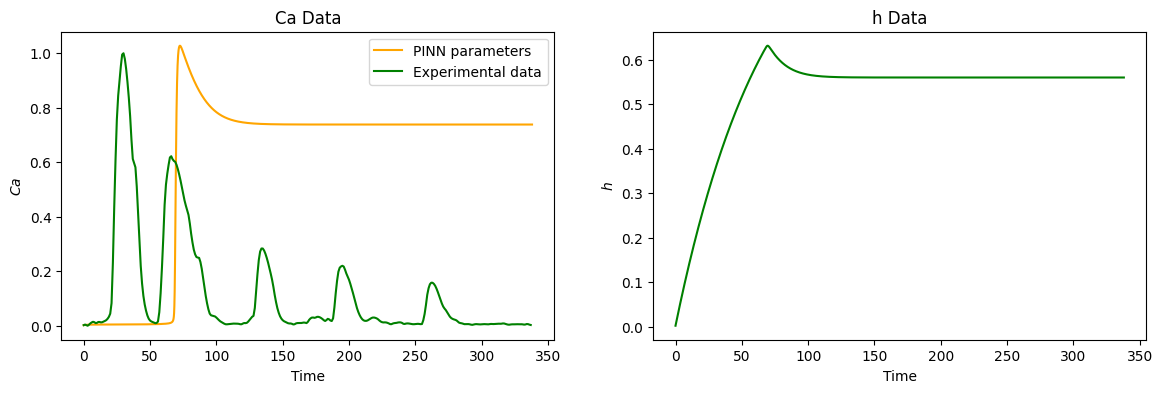

In [205]:
v2 = v2s[-1]
a2 = a2s[-1]
IP3 = IP3s[-1]
d5 = d5s[-1]
k3 = k3s[-1]

dt1 = 0.01
t1 = np.arange(0, 338, dt1)
t_exp = np.arange(0, 338, 1.0)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, 7, d5, k3, Ca0=Ca_1_norm[0], dt=dt1)

plt.figure(figsize=(14,4))

plt.subplot(121)
plt.plot(t1, Ca_euler1, c='orange', label="PINN parameters")
plt.plot(t_exp, Ca_1_norm, c='green', label="Experimental data")
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca Data")
plt.legend()

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h Data")
plt.show()

# Experimental Data - 2

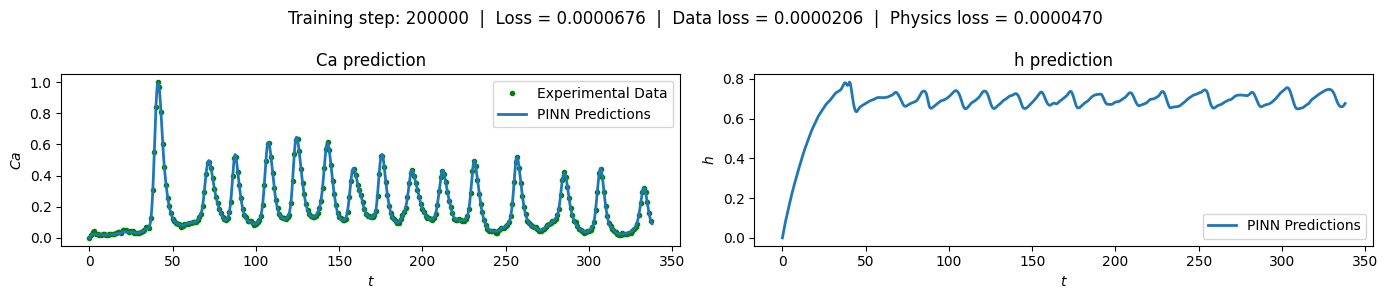

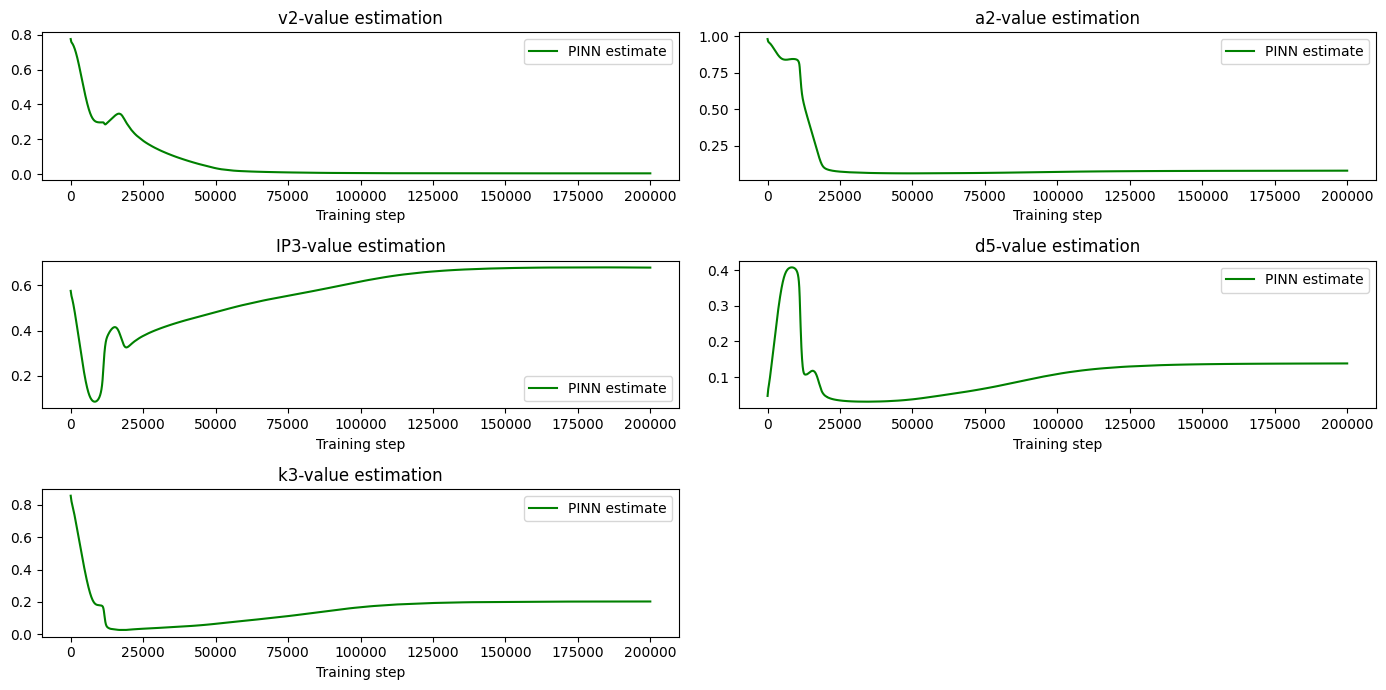

Epoch 200000 completed Successfully !


In [121]:
torch.manual_seed(42)
y0 = torch.tensor([Ca_2_norm[0], Ca_2_norm[0]]).view(1,-1)
pinn = PinnModel(hidden_units=30, num_features=3, std=0.4, y0=y0)

Ca_exp = torch.tensor(Ca_2_norm, dtype=torch.float)
t_test = torch.arange(0, 338, 0.1).view(-1, 1)
time = torch.arange(0, 338, 1.0).view(-1, 1)
t_physics = torch.linspace(0, 338, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
IP3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
d5 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
k3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))

lam1, lam2 = 1e-2, 1.5e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2, IP3, d5, k3], lr=0.0001)
epochs =  200001

v2s = []
a2s = []
IP3s = []
d5s = []
k3s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_exp)**2)

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss3 = torch.mean((res1)**2)
    loss4 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1) + lam2*(loss3 + loss4)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())
    IP3s.append(IP3.item())
    d5s.append(d5.item())
    k3s.append(k3.item())

    if i % 10000 == 0:

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        clear_output(wait=True)

        plt.figure(figsize=(14, 3))
        plt.suptitle(f"Training step: {i}  |  Loss = {loss1+loss3+loss4:.7f}  |  Data loss = {loss1:.7f}  |  Physics loss = {loss3+loss4:.7f}")
        plt.subplot(121)
        plt.plot(time.squeeze().cpu(), Ca_exp.detach().cpu(), '.g', label="Experimental Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(122)
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(14, 7))
        plt.subplot(321)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(322)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(323)
        plt.plot(IP3s, label="PINN estimate", c='green')
        plt.title("IP3-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(324)
        plt.plot(d5s, label="PINN estimate", c='green')
        plt.title("d5-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(325)
        plt.plot(k3s, label="PINN estimate", c='green')
        plt.title("k3-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if i % 1000 == 0:
       print(f"Epoch {i} completed Successfully !")


In [122]:
param_df = pd.DataFrame({
    "Parameter": ["v2", "a2", "IP3", "d5", "k3"],
    "values from PINN": [v2s[-1], a2s[-1], IP3s[-1], d5s[-1], k3s[-1]]
})

param_df

,Parameter,values from PINN
0,v2,0.003937
1,a2,0.079079
2,IP3,0.678436
3,d5,0.138222
4,k3,0.202291


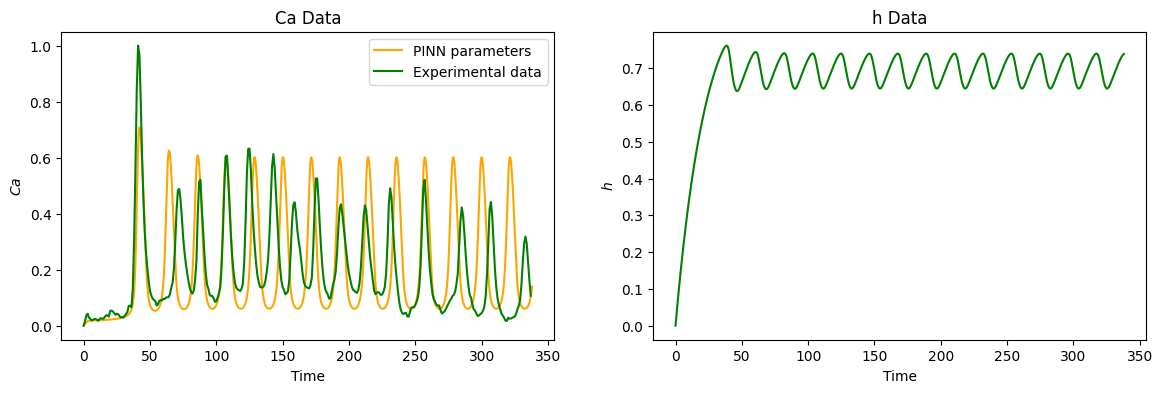

In [123]:
v2 = v2s[-1]
a2 = a2s[-1]
IP3 = IP3s[-1]
d5 = d5s[-1]
k3 = k3s[-1]

dt1 = 0.01
t1 = np.arange(0, 338, dt1)
t_exp = np.arange(0, 338, 1.0)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, Ca0=Ca_2_norm[0], dt=dt1)

plt.figure(figsize=(14,4))

plt.subplot(121)
plt.plot(t1, Ca_euler1, c='orange', label="PINN parameters")
plt.plot(t_exp, Ca_2_norm, c='green', label="Experimental data")
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca Data")
plt.legend()

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h Data")
plt.show()

# Loss Explosion

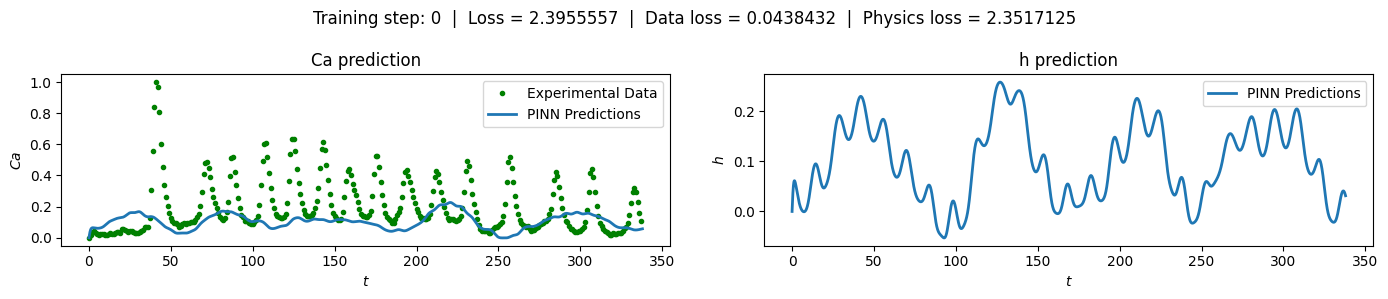

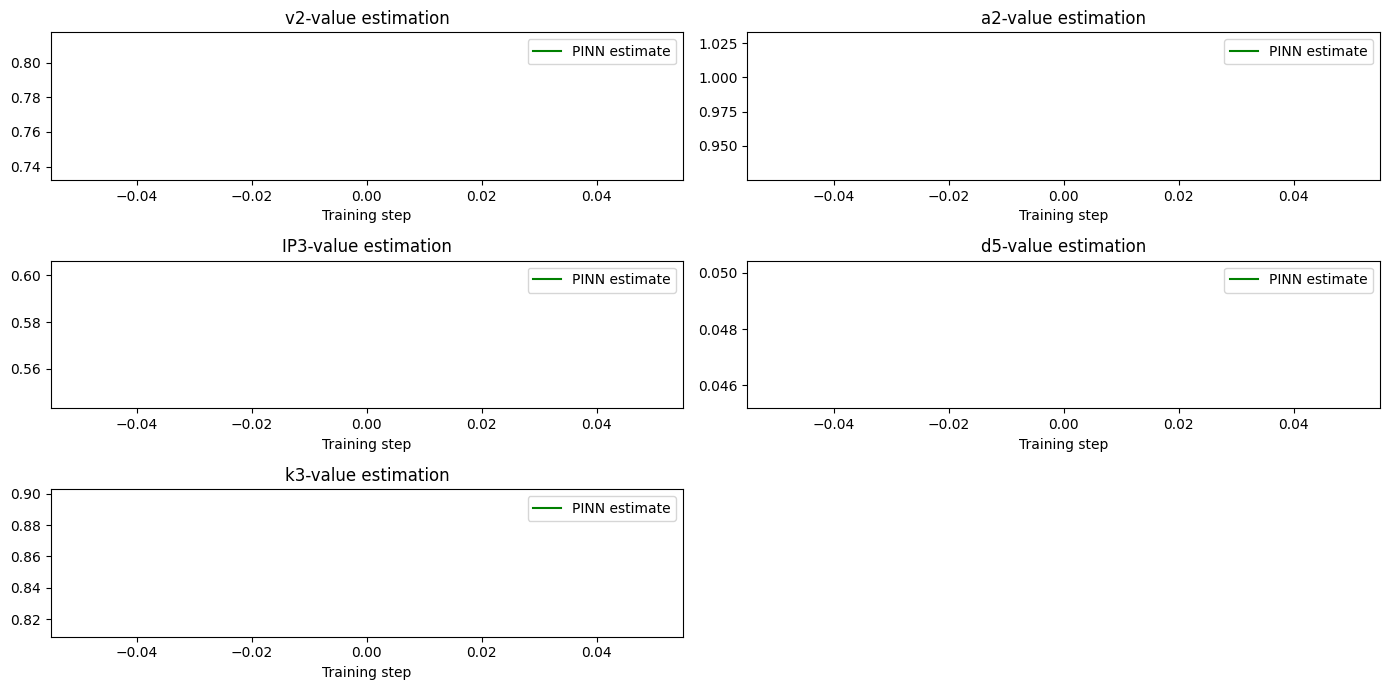

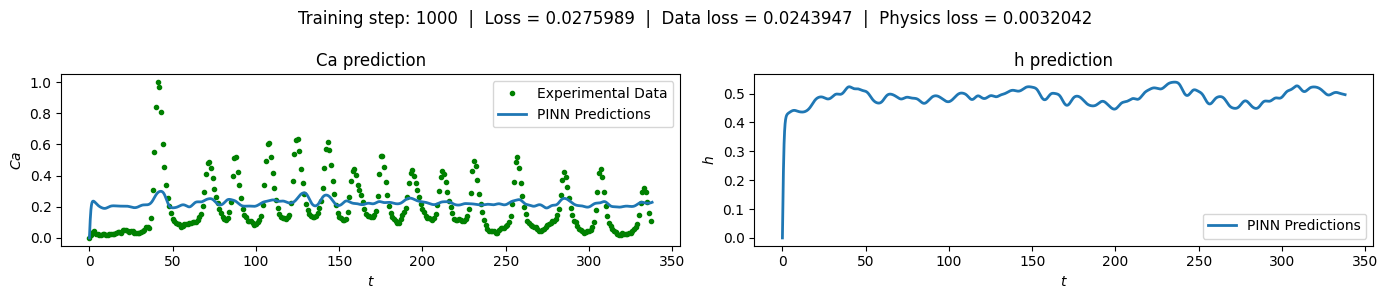

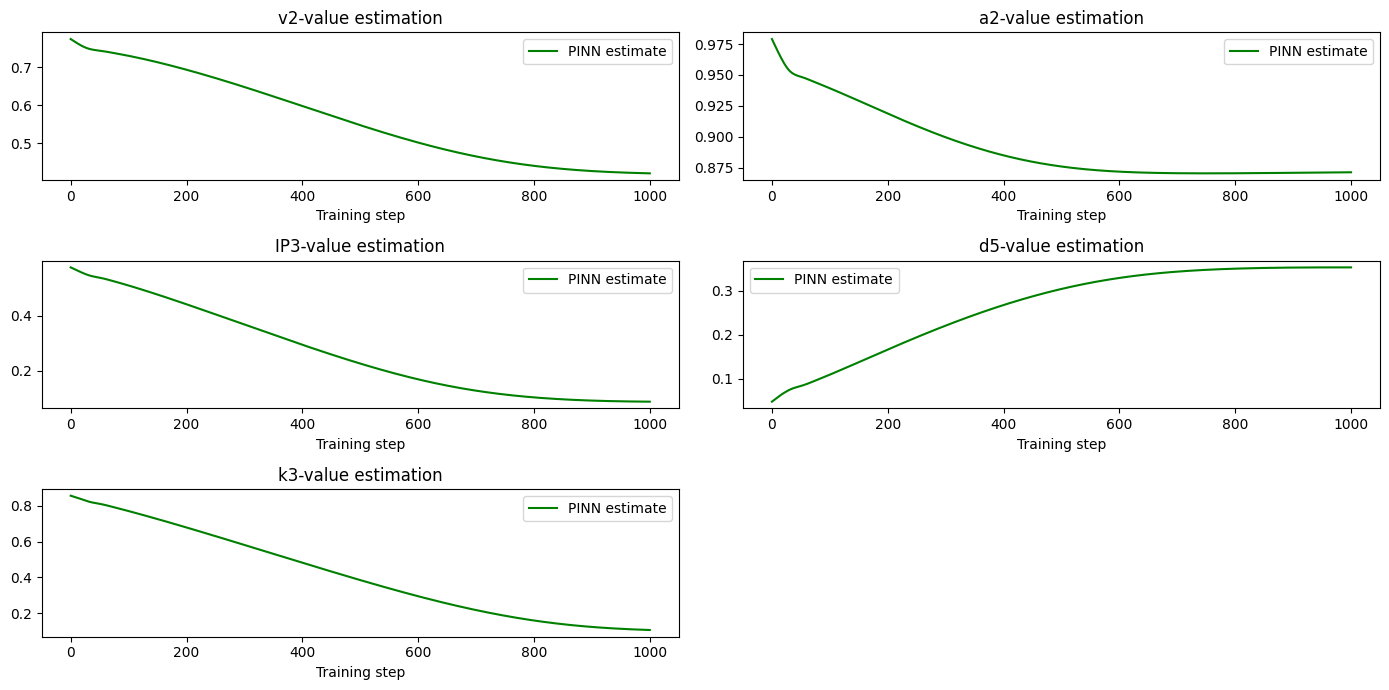

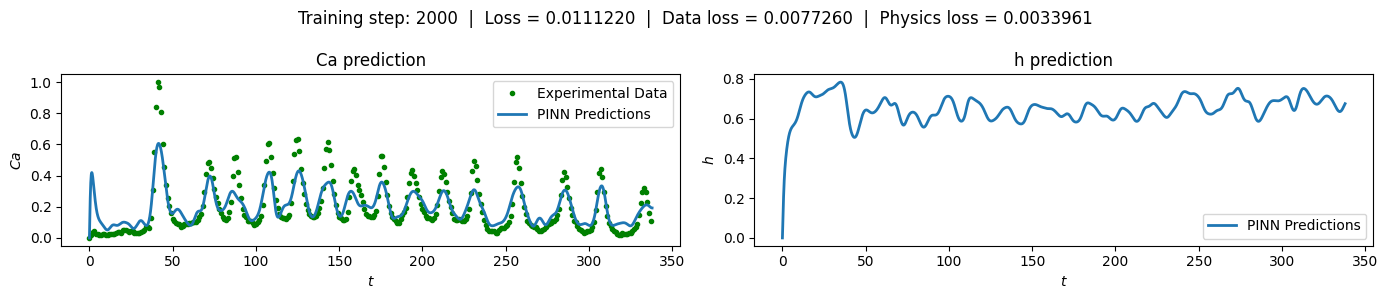

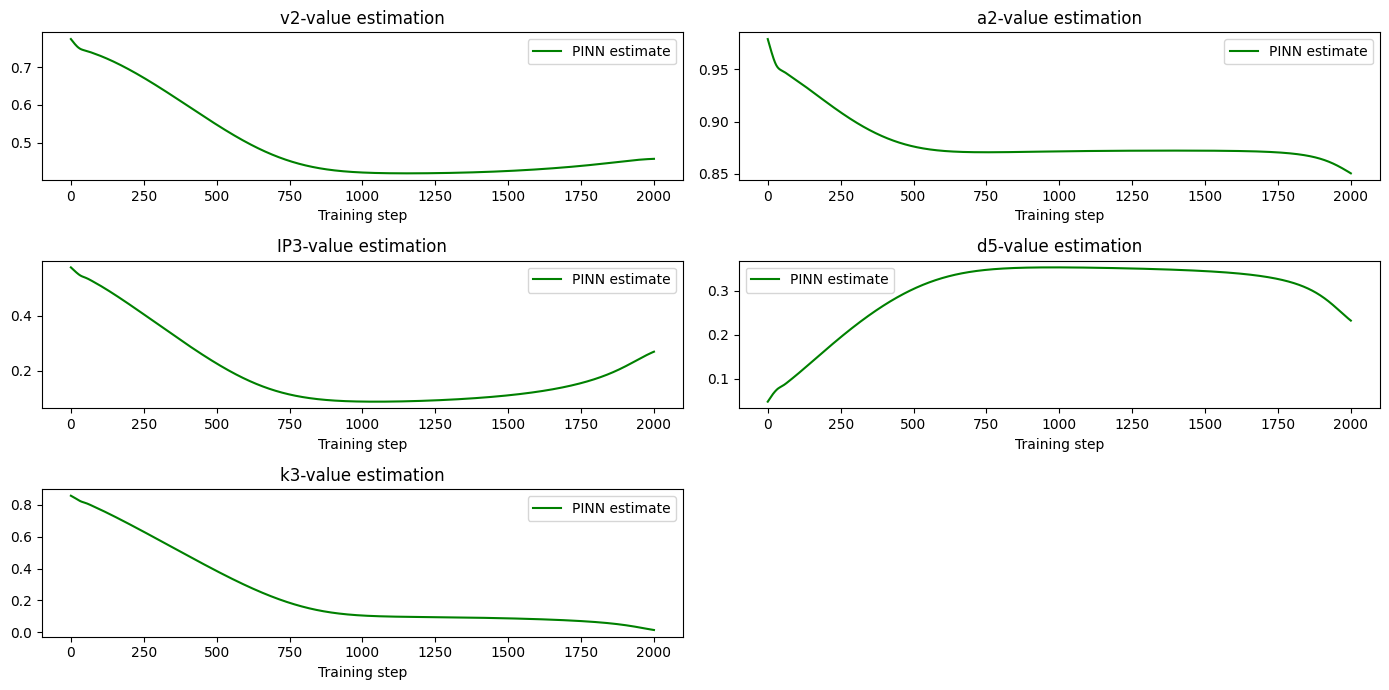

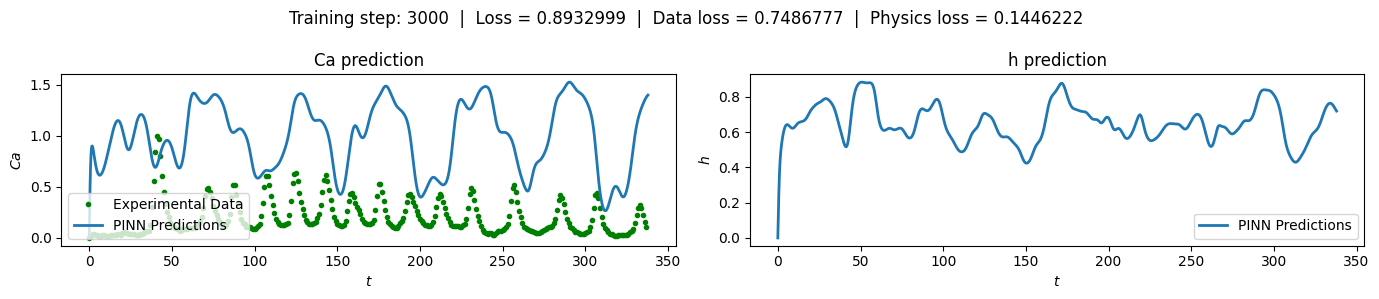

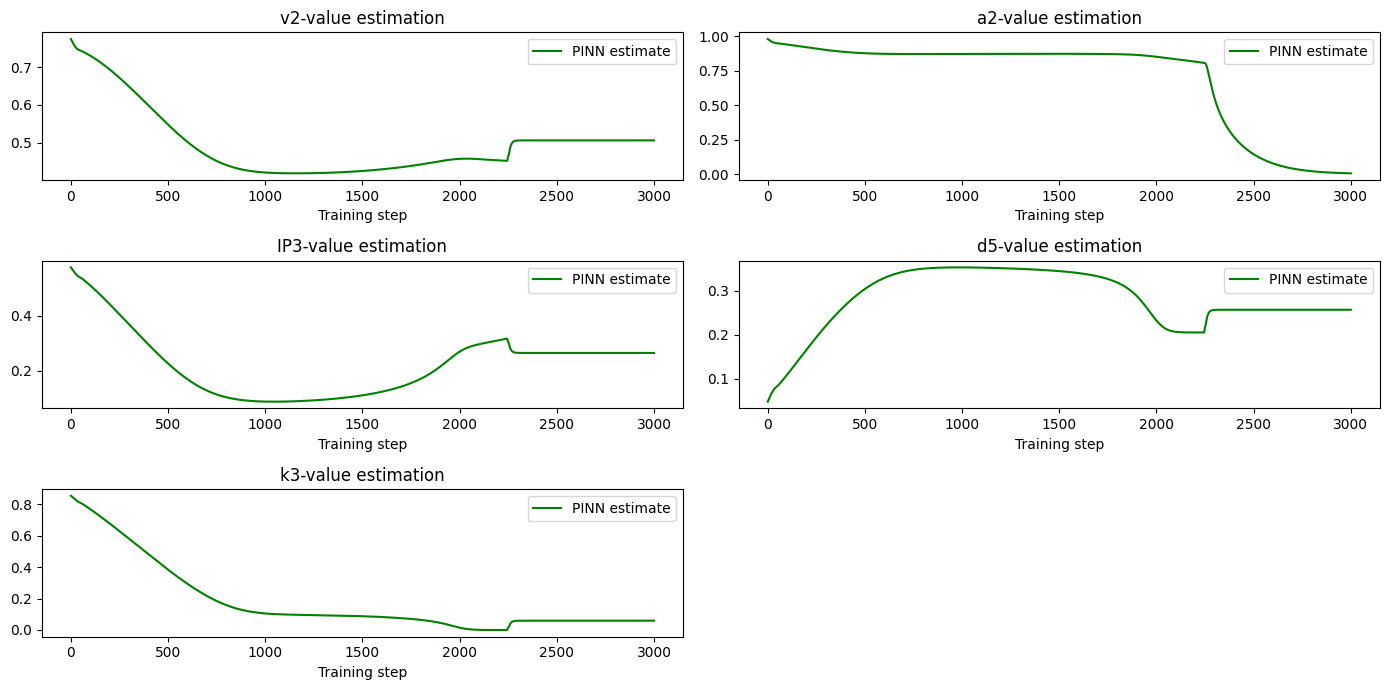

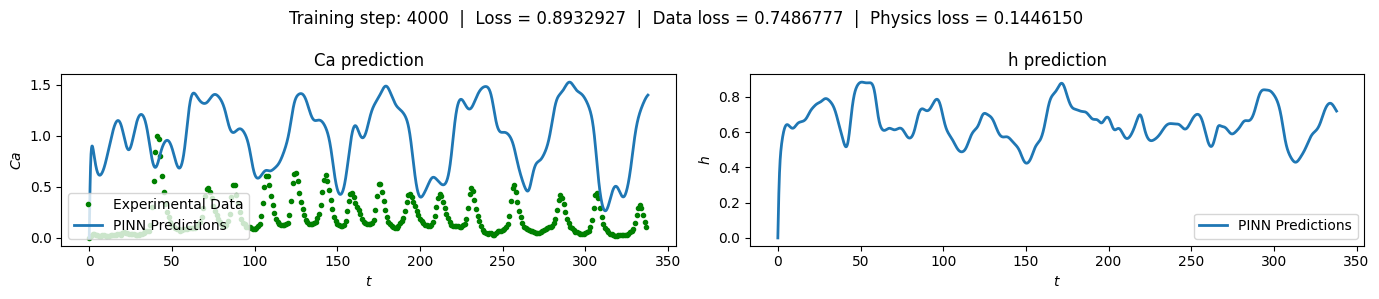

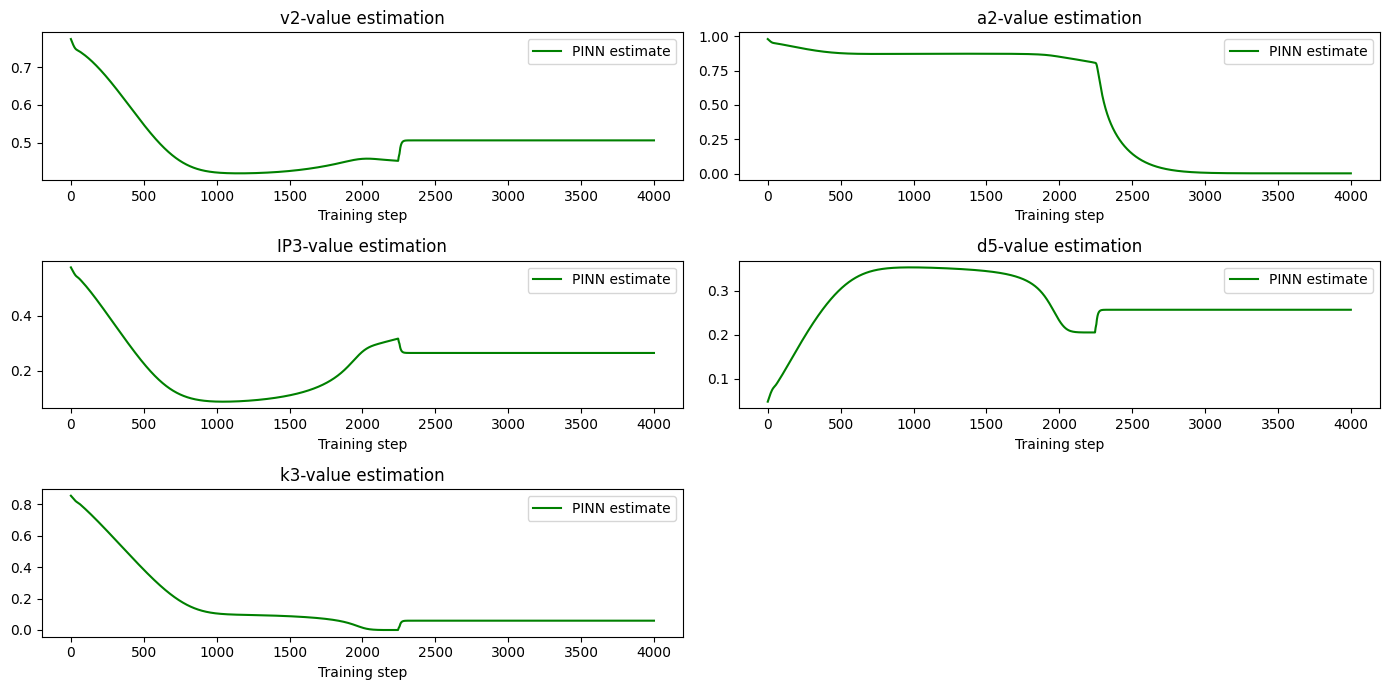

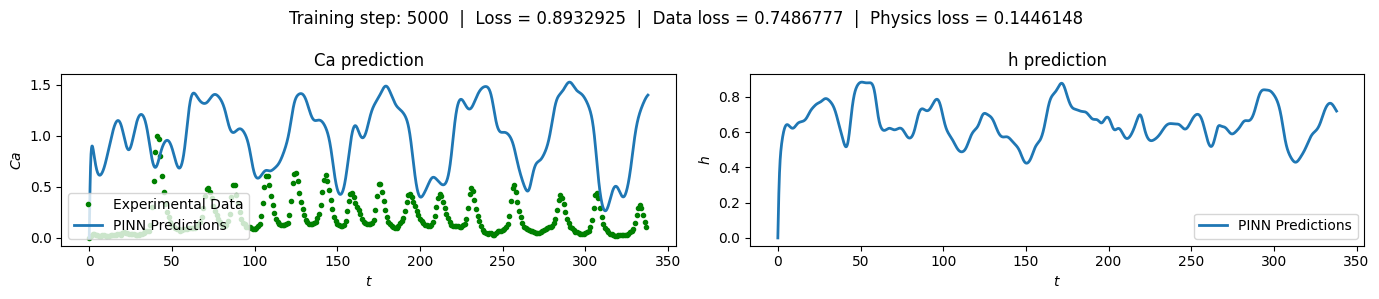

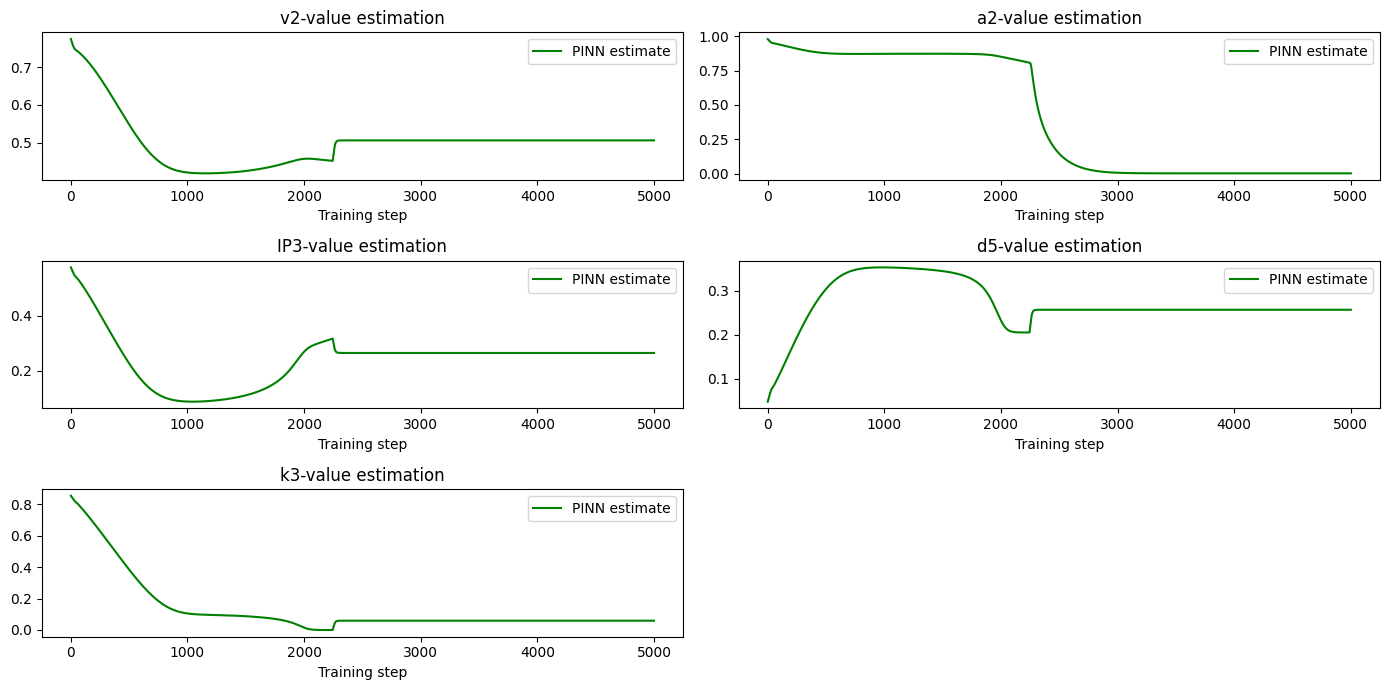

In [207]:
torch.manual_seed(42)
y0 = torch.tensor([Ca_2_norm[0], Ca_2_norm[0]]).view(1,-1)
pinn = PinnModel(hidden_units=30, num_features=3, std=0.4, y0=y0)

Ca_exp = torch.tensor(Ca_2_norm, dtype=torch.float)
t_test = torch.arange(0, 338, 0.1).view(-1, 1)
time = torch.arange(0, 338, 1.0).view(-1, 1)
t_physics = torch.linspace(0, 338, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
IP3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
d5 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
k3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))

lam1, lam2 = 1e-2, 1.5e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2, IP3, d5, k3], lr=0.001)
epochs =  5001

v2s = []
a2s = []
IP3s = []
d5s = []
k3s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_exp)**2)

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss3 = torch.mean((res1)**2)
    loss4 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1) + lam2*(loss3 + loss4)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())
    IP3s.append(IP3.item())
    d5s.append(d5.item())
    k3s.append(k3.item())

    if i % 1000 == 0:

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 3))
        plt.suptitle(f"Training step: {i}  |  Loss = {loss1+loss3+loss4:.7f}  |  Data loss = {loss1:.7f}  |  Physics loss = {loss3+loss4:.7f}")
        plt.subplot(121)
        plt.plot(time.squeeze().cpu(), Ca_exp.detach().cpu(), '.g', label="Experimental Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(122)
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(14, 7))
        plt.subplot(321)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(322)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(323)
        plt.plot(IP3s, label="PINN estimate", c='green')
        plt.title("IP3-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(324)
        plt.plot(d5s, label="PINN estimate", c='green')
        plt.title("d5-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(325)
        plt.plot(k3s, label="PINN estimate", c='green')
        plt.title("k3-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()